We are going to do the following

Train the classifier
label the unlabelled data.
Check the scores

Acquiring and cleaning the text data

In [1]:
import pandas as pd
from IPython.display import display
from nltk.corpus import stopwords
import re

df=pd.read_excel('08052019_coded_cases_training_data.xlsx')

In [2]:
df.columns

Index(['case', 'link', 'Mis_Dis', 'Mis_Dis text', 'Social_Impact',
       'Social_Impact text', 'observed behaviours', 'observed behaviours text',
       'note'],
      dtype='object')

split to 3 sets change to lower case, remove punctuation and remove stopwords

In [3]:
stop = stopwords.words('english')

from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer() 

#this is done so that i can apply lambda function without too much for loops by mapping the stem function to the words
def mapstem(lst):
    return [stemmer.stem(i) for i in lst]

def maplem(lst):
    return [lemmatizer.lemmatize(i) for i in lst]

#takes a label,text df and processes the df
def txt_preprocessing(df):
    col = df.columns[1]
    #lower case
    df[col] = df[col].apply(lambda x: " ".join(x.lower() for x in x.split()))
    #remove "\n"
    df = df.replace('\n',' ', regex=True)
    #remove punctuation
    df[col] = df[col].str.replace('[^\w\s]','')
    #remove stopwords
    df[col] = df[col].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    #tokenize words
    df[col] = df[col].apply(word_tokenize)
    #stem words
    df[col] = df[col].apply(lambda x: maplem(x))
    #stitching
    df[col] = df[col].apply(lambda x: ' '.join(x))
    
    return df



mis_dis = df[['Mis_Dis', 'Mis_Dis text']].dropna()
social_impact = df[['Social_Impact','Social_Impact text']].dropna()
ob_behaviour = df[['observed behaviours', 'observed behaviours text']].dropna()

#cleaning the df into training data
mis_dis=txt_preprocessing(mis_dis)
mis_dis.columns=['target','data']
social_impact=txt_preprocessing(social_impact)
social_impact.columns=['target','data']
ob_behaviour=txt_preprocessing(ob_behaviour)
ob_behaviour.columns=['target','data']
combi=pd.concat([mis_dis,social_impact])

display(mis_dis)

,target,data
0,Smear,police said group linked free papua movement o...
1,Smear,resident one village banti said security force...
2,Smear,indonesian military general gatot nurmantyo na...
3,Smear,hendrik wanmang described commander armed grou...
4,Rumour,following series bombing incident chain messag...
5,Rumour,specific threat particular target therefore te...
6,Rumour,public called avoid spreading unverified infor...
7,Rumour,social medium user shared unverified text mess...
8,Rumour,also mentioned certain psychologist counseled ...
9,Rumour,another forwarded message claimed armed force ...


In [4]:
mis_dis['target'].value_counts()

Rumour               47
other                47
Smear                29
Conspiracy Theory    21
Name: target, dtype: int64

# Training the Data
downloading the trainings and testing set

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
import seaborn as sns;sns.set()
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from sklearn import metrics
import IPython.display as display
from sklearn.metrics import classification_report

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def make_nb_model(df):
    train, test = train_test_split(df, 
                                   test_size=0.2,
                                   stratify=df.target,
                                   random_state = 4
                                  )
    '''
    print(train.shape, train.target.value_counts())
    print(test.shape, test.target.value_counts())
    '''

    model = make_pipeline(CountVectorizer(),MultinomialNB())

    model.fit(train.data,train.target) #see the above for example
    labels = model.predict(test.data)
    
    #remove the '''''' to show the confusion matrix and accuracy score
    
    mat = confusion_matrix(test.target,labels)
    sns.heatmap(mat.T,square=True,fmt='d',cbar=False,annot=True)
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    
    print("accuracy",metrics.accuracy_score(test.target, labels))
    #print(metrics.roc_auc_score(test.target, labels)) #above 0.5 is nice, 1 is best
    
    #cross-validating
    print("cross validating",cross_val_score(model, train.data, train.target, cv=10),cross_val_score(model, train.data, train.target, cv=5).mean())
    
    accuracy = cross_val_score(model, train.data, train.target, cv=5).mean()
    
    print(classification_report(test.target, labels))
    
    return model, train, accuracy

def make_nb_model_test_vect(df):
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.feature_extraction.text import TfidfTransformer
    from sklearn.feature_extraction.text import HashingVectorizer
    
    train, test = train_test_split(df, test_size=0.2, stratify=df.target,
                                   random_state = 4)
    print(train.shape, train.target.value_counts())
    print(test.shape, test.target.value_counts())
    
    vectorisers = [CountVectorizer(),TfidfVectorizer(),TfidfTransformer(),HashingVectorizer()]
    
    for vectoriser in vectorisers:
        print(str(vectoriser))
        try:
            model = make_pipeline(vectoriser,MultinomialNB())

            model.fit(train.data,train.target) #see the above for example
            labels = model.predict(test.data)

            mat = confusion_matrix(test.target,labels)
            sns.heatmap(mat.T,square=True,fmt='d',cbar=False,annot=True)
            plt.xlabel('true label')
            plt.ylabel('predicted label')

            print("accuracy",metrics.accuracy_score(test.target, labels))
            
            
            #cross-validating
            print("cross validating",cross_val_score(model, train.data, train.target, cv=5),cross_val_score(model, train.data, train.target, cv=5).mean())

            accuracy = cross_val_score(model, train.data, train.target, cv=5).mean()

            print(classification_report(test.target, labels))
            
            #print('roc_score',metrics.roc_auc_score(test.target, test.data)) #above 0.5 is nice, 1 is best
        except:
            print('error')


accuracy 0.7931034482758621
cross validating [0.61538462 0.76923077 0.69230769 0.58333333 0.75       0.66666667
 0.83333333 0.4        1.         0.88888889] 0.7085879917184265
                   precision    recall  f1-score   support

Conspiracy Theory       0.67      0.50      0.57         4
           Rumour       0.83      1.00      0.91        10
            Smear       0.60      0.50      0.55         6
            other       0.89      0.89      0.89         9

        micro avg       0.79      0.79      0.79        29
        macro avg       0.75      0.72      0.73        29
     weighted avg       0.78      0.79      0.78        29



ValueError: multiclass format is not supported

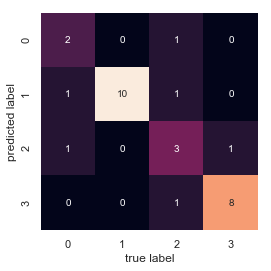

In [12]:
mis_dis_model, mis_dis_train, mis_dis_accuracy = make_nb_model(mis_dis) 

(115, 2) other                38
Rumour               37
Smear                23
Conspiracy Theory    17
Name: target, dtype: int64
(29, 2) Rumour               10
other                 9
Smear                 6
Conspiracy Theory     4
Name: target, dtype: int64
CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)
accuracy 0.7931034482758621
cross validating [0.68       0.6        0.73913043 0.66666667 0.85714286] 0.7085879917184265
                   precision    recall  f1-score   support

Conspiracy Theory       0.67      0.50      0.57         4
           Rumour       0.83      1.00      0.91        10
            Smear       0.60      0.50      0.55         6
    

C:\Users\User\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


TypeError: 'NoneType' object is not iterable

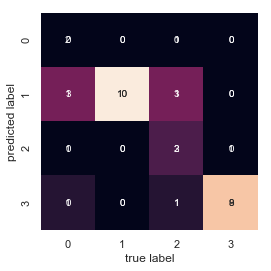

In [7]:
#from the testing of the vectorisers, countvectorisers appear to be the best
mis_dis_model, mis_dis_train, mis_dis_accuracy = make_nb_model_test_vect(mis_dis)

accuracy 0.5
cross validating [0.         0.5        0.25       0.25       0.5        0.25
 0.33333333 0.33333333 0.5        0.5       ] 0.30761904761904757
                            precision    recall  f1-score   support

Erode trust in authorities       0.50      0.33      0.40         3
                  Identity       0.00      0.00      0.00         1
   Inciting fear and panic       0.67      1.00      0.80         4
             Public safety       0.00      0.00      0.00         2

                 micro avg       0.50      0.50      0.50        10
                 macro avg       0.29      0.33      0.30        10
              weighted avg       0.42      0.50      0.44        10



C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in 

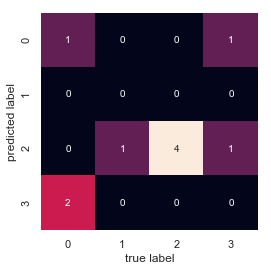

In [8]:
social_impact_model, social_impact_train, social_impact_accuracy = make_nb_model(social_impact)

accuracy 0.5263157894736842
cross validating [0.57894737 0.58823529 0.47058824 0.5625     0.625      0.4375
 0.46666667 0.71428571 0.54545455 0.54545455] 0.5376205410479604
                            precision    recall  f1-score   support

         Conspiracy Theory       0.50      0.50      0.50         4
Erode trust in authorities       0.00      0.00      0.00         3
                  Identity       0.00      0.00      0.00         1
   Inciting fear and panic       0.50      0.25      0.33         4
             Public safety       0.00      0.00      0.00         2
                    Rumour       0.47      0.78      0.58         9
                     Smear       0.71      0.83      0.77         6
                     other       0.71      0.56      0.63         9

                 micro avg       0.53      0.53      0.53        38
                 macro avg       0.36      0.36      0.35        38
              weighted avg       0.50      0.53      0.50        38



C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in 

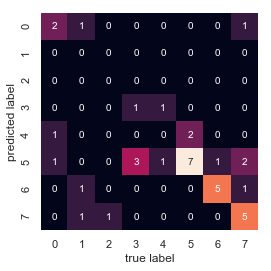

In [9]:
combi_model, combi_train, combi_accuracy = make_nb_model(combi)

# Using the model

In [10]:
def predict_category(text,model,train):
    pred = model.predict([text])
    pred_prob = pd.DataFrame(model.predict_proba([text]),columns=model.classes_).sort_values(by=0, ascending=False, axis=1)
    df = pred_prob
    df['predicted'] = pred
    return df

In [11]:
#testing
from IPython.display import display

#use this value as a discard threshold
empty = ''
conspiracy_true_text = 'National Police arrested Ahmad Rifai, 37, for allegedly spreading fake news through a  Facebook post in which he said the suicide bomb attack that killed three police officers and injured 16 others in East Jakarta last week, was a police plot.'
rumour_true_text = 'Netizens worried on circulated rumors that Baguio City and other municipalities in Benguet was on red alert after alleged members of New People’s Army burned two trucks containing copper concentrate in Ampucao itogon, Benguet Thursday.'
misinformation_true_text = 'Hendrik Wanmang, who described himself as a commander of the armed group that goes by the Indonesian acronym TNP, said in an interview on Friday (local time) that Banti and Kimbeli villagers cannot go to an area the separatists defined as a battlefield with security forces because it is unsafe.But otherwise villagers are free to go to their farms and move about as they please, he said. On Thursday, police said a group of about 100, including 25 gunmen, were occupying the two villages and preventing 1,300 people from leaving.'

display("empty mis dis",predict_category(empty,mis_dis_model, mis_dis_train))
display("conspiracy theory",predict_category(conspiracy_true_text,mis_dis_model, mis_dis_train))
display("rumour",predict_category(rumour_true_text,mis_dis_model, mis_dis_train))
display("misinformation",predict_category(misinformation_true_text,mis_dis_model, mis_dis_train))


'empty mis dis'

,other,Rumour,Smear,Conspiracy Theory,predicted
0,0.330435,0.321739,0.2,0.147826,other


'conspiracy theory'

,Conspiracy Theory,Rumour,other,Smear,predicted
0,0.999974,0.000026,6.855880e-09,3.888687e-09,Conspiracy Theory


'rumour'

,Rumour,Smear,Conspiracy Theory,other,predicted
0,1.0,6.403741e-08,5.624542e-09,4.450988e-09,Rumour


'misinformation'

,Smear,other,Rumour,Conspiracy Theory,predicted
0,1.0,1.653988e-11,4.460561e-12,9.981918e-13,Smear


In [12]:
import glob

path = r'C:\Users\User\Desktop\00_Pipeline_0\0.2 Data Collection using GTD\h5files_2015_2018'

all_files = glob.glob(path + "/*.h5")

li = []

for filename in all_files:
    li.append(filename)
li

['C:\\Users\\User\\Desktop\\00_Pipeline_0\\0.2 Data Collection using GTD\\h5files_2015_2018\\201501010014_11345.h5',
 'C:\\Users\\User\\Desktop\\00_Pipeline_0\\0.2 Data Collection using GTD\\h5files_2015_2018\\201501010014_13538.h5',
 'C:\\Users\\User\\Desktop\\00_Pipeline_0\\0.2 Data Collection using GTD\\h5files_2015_2018\\201501010014_13539.h5',
 'C:\\Users\\User\\Desktop\\00_Pipeline_0\\0.2 Data Collection using GTD\\h5files_2015_2018\\201501010014_7553.h5',
 'C:\\Users\\User\\Desktop\\00_Pipeline_0\\0.2 Data Collection using GTD\\h5files_2015_2018\\201501010014_7554.h5',
 'C:\\Users\\User\\Desktop\\00_Pipeline_0\\0.2 Data Collection using GTD\\h5files_2015_2018\\201501010014_7555.h5',
 'C:\\Users\\User\\Desktop\\00_Pipeline_0\\0.2 Data Collection using GTD\\h5files_2015_2018\\201501010014_7556.h5',
 'C:\\Users\\User\\Desktop\\00_Pipeline_0\\0.2 Data Collection using GTD\\h5files_2015_2018\\201501010014_7557.h5',
 'C:\\Users\\User\\Desktop\\00_Pipeline_0\\0.2 Data Collection using 

In [13]:
#takes a series and processes the text
def txt_preprocess(series):
    #convert to df
    df = series.to_frame().transpose()
    df.columns=['link','gtd_id','txts']
    #melting list
    df = df.txts.apply(pd.Series)\
    .merge(df, right_index = True, left_index = True)\
    .drop(["txts"], axis = 1)\
    .melt(id_vars = ['link','gtd_id'], value_name = "txt") \
    .drop("variable", axis = 1) \
    .drop_duplicates()\
    .dropna()
    #display(df.tail())
    #display(type(df['txt'][0]))
    
    col = 'txt'
    #lower case
    df[col] = df[col].apply(lambda x: " ".join(x.lower() for x in x.split()))
    #remove "\n"
    df = df.replace('\n',' ', regex=True)
    #remove punctuation
    df[col] = df[col].str.replace('[^\w\s]','')
    #remove stopwords
    df[col] = df[col].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    
    #tokenize words
    df[col] = df[col].apply(word_tokenize)
    #stem words
    df[col] = df[col].apply(lambda x: maplem(x))
    #stitching
    df[col] = df[col].apply(lambda x: ' '.join(x))
    
    return df

#this method quite computationally expensive cos you are running things at o(n^2)
    

#gives the maximum value of h5
def label_h5(h5):
    series=pd.read_pickle(h5)
    #print(series[2])
    #print(type(series[2]))
    if series[2] == []:
        raise NothingToAnalyseError
        print('Nothing to analyse!')
    else:
        frame = txt_preprocess(series)
        #print('frame len:' + str(len(frame)))
        #display(frame)

        #create a df with predicted values and text
        def pred_df(frame,model,train):
            df = pd.DataFrame()
            for i in range(len(frame)):
                txt = frame['txt'].iloc[i]
                dfa= predict_category(txt,model,train)
                df = pd.concat([df,dfa], sort=True) #sort=True to silence warnings
            df = df.reset_index(drop=True)
            return df

        df2=pred_df(frame,mis_dis_model, mis_dis_train)
        df3=pred_df(frame,social_impact_model,social_impact_train)


        frame = pd.concat([df2,df3, frame], axis=1, sort=True)
        frame = frame.dropna()
        frame = frame.reset_index()
        
        #remove na
        '^\s+$'
        
        
        frame['rm_space'] = frame['txt'].apply(lambda x: bool(re.search(r"^\s+$",x)))
        frame = frame[frame['rm_space']==False]
        frame['rm_space'] = frame['txt'].apply(lambda x: len(x)>0)
        frame = frame[frame['rm_space']==True]
        frame = frame.reset_index(drop=True)
        return frame
    
def maxframe(frame):
    def maxcol(col,frame):
        val = pd.DataFrame([frame[col].max()])
        val.columns=[col]
        #print(val)
        #print('id: '+ str(frame[col].idxmax()))
        #print([frame['txt'].iloc[frame[col].idxmax()]])
        txt = pd.DataFrame([frame['txt'].iloc[frame[col].idxmax()]])
        txt.columns=[col+' text']
        #print(txt)
        maximum_col = pd.concat([val,txt],axis=1)
        return maximum_col
    
    cols = ['Conspiracy Theory','Rumour','Smear','Erode trust in authorities','Identity','Inciting fear and panic','Public safety']
    maxframe=pd.DataFrame()
    for i in cols:
        lframe = maxcol(i,frame)
        maxframe=pd.concat([maxframe,lframe],axis=1)
    
    link = pd.DataFrame([frame['link'][0]])
    link.columns=['link']
    maxframe = pd.concat([maxframe,link],axis=1)
    
    return maxframe



In [14]:
li[1597]

'C:\\Users\\User\\Desktop\\00_Pipeline_0\\0.2 Data Collection using GTD\\h5files_2015_2018\\201506200017_6693.h5'

In [22]:
pd.read_pickle(li[46])

0       https://www.bbc.com/news/world-africa-29018522
1                                         201501080051
2    [\n /*<![CDATA[*/ (function() { if (window.bbc...
Name: 4, dtype: object

In [23]:
label_h5(li[46])

,index,Conspiracy Theory,Rumour,Smear,other,predicted,Erode trust in authorities,Identity,Inciting fear and panic,Public safety,predicted,link,gtd_id,txt,rm_space
0,0,8.951065e-66,3.832225e-78,1.977471e-85,1.000000e+00,other,5.337270e-07,6.119444e-13,0.999999,3.259658e-08,Inciting fear and panic,https://www.bbc.com/news/world-africa-29018522,2.015011e+11,cdata function windowbbcdotcom bbcdotcomconfig...,True
1,2,1.478261e-01,3.217391e-01,2.000000e-01,3.304348e-01,other,3.055556e-01,2.777778e-02,0.444444,2.222222e-01,Inciting fear and panic,https://www.bbc.com/news/world-africa-29018522,2.015011e+11,cdata function windowbbcdotcom bbcdotcomconfig...,True
2,4,6.244840e-02,2.140660e-01,5.967207e-02,6.638135e-01,other,1.518864e-01,1.928615e-02,0.581621,2.472068e-01,Inciting fear and panic,https://www.bbc.com/news/world-africa-29018522,2.015011e+11,cdata function var wallpaper windowbbcdotcom b...,True
3,6,1.478261e-01,3.217391e-01,2.000000e-01,3.304348e-01,other,3.055556e-01,2.777778e-02,0.444444,2.222222e-01,Inciting fear and panic,https://www.bbc.com/news/world-africa-29018522,2.015011e+11,homepageaccessibility linksskip contentaccessi...,True
4,8,2.693157e-01,2.543069e-01,1.926475e-01,2.837299e-01,other,3.055556e-01,2.777778e-02,0.444444,2.222222e-01,Inciting fear and panic,https://www.bbc.com/news/world-africa-29018522,2.015011e+11,homepage,True
5,9,1.478261e-01,3.217391e-01,2.000000e-01,3.304348e-01,other,3.055556e-01,2.777778e-02,0.444444,2.222222e-01,Inciting fear and panic,https://www.bbc.com/news/world-africa-29018522,2.015011e+11,accessibility linksskip contentaccessibility help,True
6,10,1.295408e-01,2.274453e-01,1.560783e-01,4.869355e-01,other,3.055556e-01,2.777778e-02,0.444444,2.222222e-01,Inciting fear and panic,https://www.bbc.com/news/world-africa-29018522,2.015011e+11,bbc accountrequireidctastatusbar function stat...,True
7,11,1.019314e-01,1.443763e-01,1.093707e-01,6.443217e-01,other,3.055556e-01,2.777778e-02,0.444444,2.222222e-01,Inciting fear and panic,https://www.bbc.com/news/world-africa-29018522,2.015011e+11,bbc account,True
8,14,3.596549e-02,2.202342e-04,2.242099e-04,9.635901e-01,other,7.043102e-01,2.971438e-02,0.014621,2.513545e-01,Erode trust in authorities,https://www.bbc.com/news/world-africa-29018522,2.015011e+11,homenewssportweatheriplayersoundscbbccbeebiesf...,True
9,15,1.764973e-01,1.807666e-02,1.668792e-02,7.887381e-01,other,4.474333e-01,1.983874e-02,0.125297,4.074310e-01,Erode trust in authorities,https://www.bbc.com/news/world-africa-29018522,2.015011e+11,searchsearch bbcsearch bbc,True


In [24]:
label_h5(li[1])['Smear'].idxmax()

15

In [25]:
frame = label_h5(li[1])
pd.DataFrame([frame['txt'].iloc[137])

SyntaxError: invalid syntax (<ipython-input-25-e0e46ffc1ec2>, line 2)

In [26]:
maxframe(label_h5(li[57])) #too huge #need to debug the maxframe

ValueError: attempt to get argmax of an empty sequence

In [15]:
len(li) #to know how much i need

16250

In [16]:
for i in range(1318, 16251):
    try:
        print(i,end='\r')
        d=maxframe(label_h5(li[i]))
        #print(ndf,end='\r')
        #print(d.columns)
        d[['Conspiracy Theory', 'Conspiracy Theory text','link']].copy().to_csv('highest_link_score_ConspiracyTheory.csv',mode='a',header=None)
        d[['Rumour', 'Rumour text','link']].copy().to_csv('highest_link_score_rumour.csv',mode='a',header=None)
        d[['Smear', 'Smear text','link']].copy().to_csv('highest_link_score_smear.csv',mode='a',header=None)
        d[['Identity', 'Identity text','link']].copy().to_csv('highest_link_score_identity.csv',mode='a',header=None)
        d[['Inciting fear and panic', 'Inciting fear and panic text','link']].copy().to_csv('highest_link_score_fear.csv',mode='a',header=None)
        d[['Public safety', 'Public safety text','link']].copy().to_csv('highest_link_score_safety.csv',mode='a',header=None)

        
        
        #d.to_csv('highest_link_score2.csv',mode='a',header=None)
    except:
        continue

In [19]:
#for self-sourced data
import glob

path = r'C:\Users\User\Desktop\00_Pipeline_0\0.1 Data Collection using self-sourced data\2019files_selfsourced'

all_files = glob.glob(path + "/*.h5")

li = []

for filename in all_files:
    li.append(filename)
li

['C:\\Users\\User\\Desktop\\00_Pipeline_0\\0.1 Data Collection using self-sourced data\\2019files_selfsourced\\ID0_0.h5',
 'C:\\Users\\User\\Desktop\\00_Pipeline_0\\0.1 Data Collection using self-sourced data\\2019files_selfsourced\\ID0_199.h5',
 'C:\\Users\\User\\Desktop\\00_Pipeline_0\\0.1 Data Collection using self-sourced data\\2019files_selfsourced\\ID0_224.h5',
 'C:\\Users\\User\\Desktop\\00_Pipeline_0\\0.1 Data Collection using self-sourced data\\2019files_selfsourced\\ID0_321.h5',
 'C:\\Users\\User\\Desktop\\00_Pipeline_0\\0.1 Data Collection using self-sourced data\\2019files_selfsourced\\ID0_331.h5',
 'C:\\Users\\User\\Desktop\\00_Pipeline_0\\0.1 Data Collection using self-sourced data\\2019files_selfsourced\\ID0_363.h5',
 'C:\\Users\\User\\Desktop\\00_Pipeline_0\\0.1 Data Collection using self-sourced data\\2019files_selfsourced\\ID0_458.h5',
 'C:\\Users\\User\\Desktop\\00_Pipeline_0\\0.1 Data Collection using self-sourced data\\2019files_selfsourced\\ID0_466.h5',
 'C:\\User

In [20]:
len(li)

915

In [22]:
for i in range(len(li)+1):
    try:
        print(i,end='\r')
        d=maxframe(label_h5(li[i]))
        #print(ndf,end='\r')
        #print(d.columns)
        d[['Conspiracy Theory', 'Conspiracy Theory text','link']].copy().to_csv('highest_link_score_ConspiracyTheory.csv',mode='a',header=None)
        d[['Rumour', 'Rumour text','link']].copy().to_csv('highest_link_score_rumour.csv',mode='a',header=None)
        d[['Smear', 'Smear text','link']].copy().to_csv('highest_link_score_smear.csv',mode='a',header=None)
        d[['Identity', 'Identity text','link']].copy().to_csv('highest_link_score_identity.csv',mode='a',header=None)
        d[['Inciting fear and panic', 'Inciting fear and panic text','link']].copy().to_csv('highest_link_score_fear.csv',mode='a',header=None)
        d[['Public safety', 'Public safety text','link']].copy().to_csv('highest_link_score_safety.csv',mode='a',header=None)

        
        
        #d.to_csv('highest_link_score2.csv',mode='a',header=None)
    except:
        continue

In [ ]:
ct_df = pd.read_csv('highest_link_score_ConspiracyTheory.csv',header=None)
ct_df.columns = ['junk','score','txt','link']
ct_df['predicted_category'] = 'conspiracy theory'
ct_df = ct_df.drop('junk',axis=1)
ct_df.sort_values(by='score',ascending=False)

In [ ]:
ct_df.iloc[853]['txt']

In [ ]:
predict_category(ct_df.iloc[853]['txt'],mis_dis_model, mis_dis_train)